In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

import numpy as np
from utils import trim_state_dict_name, Flatten
from torch.autograd import Variable

from resnet3D import resnet50

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.benchmark = True

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

In [3]:
def get_feature_extractor():
    model = resnet50(shortcut_type='B')
    model.conv_seg = nn.Sequential(nn.AdaptiveAvgPool3d((1, 1, 1)),
                                   Flatten()) # (N, 512)
    # checkpoint resnet_50.pth comes from https://github.com/Tencent/MedicalNet
    ckpt = torch.load("../gnn/ckpt/pretrain/resnet_50.pth")
    ckpt = trim_state_dict_name(ckpt["state_dict"])
    model.load_state_dict(ckpt)
    model = nn.DataParallel(model).cuda()
    model.eval()
    print("Feature extractor weights loaded")
    return model

model = get_feature_extractor()

Feature extractor weights loaded


In [3]:
save_step = 78000
batch_size = 2
img_size = 256
num_samples=500
dims=2048

## HA-GAN

In [4]:
from Model_Alpha_GAN_256_SN_GN_v4_4_eval import Generator, Encoder, Sub_Encoder

latent_dim = 1024
basename = "256_1024_HA_GAN_Brain_GSP"

In [5]:
G = Generator(noise=latent_dim, mode="eval")

ckpt_path = "./checkpoint/"+basename+"/G_iter"+str(save_step)+".pth"
ckpt = torch.load(ckpt_path)
ckpt = trim_state_dict_name(ckpt)
G.load_state_dict(ckpt)

print(save_step, "step weights loaded.")
del ckpt

G = nn.DataParallel(G).cuda()
G.eval()

torch.cuda.empty_cache()

78000 step weights loaded.


In [6]:
pred_arr = np.empty((num_samples, dims))

for i in range(num_samples//batch_size):
    if i % 10 == 0:
        print('\rPropagating batch %d' % i, end='', flush=True)
    with torch.no_grad():
        noise = torch.randn((batch_size, latent_dim)).cuda()
        x_rand = G(noise, 0) # dumb index 0, not used
        x_rand = x_rand.detach()
        pred = model(x_rand)

    if (i+1)*batch_size > pred_arr.shape[0]:
        pred_arr[i*batch_size:] = pred.cpu().numpy()
    else:
        pred_arr[i*batch_size:(i+1)*batch_size] = pred.cpu().numpy()

Propagating batch 240

In [7]:
np.save("./results/pred_arr_GSP_HA_GAN.npy", pred_arr)

## HA-GAN w/o Encoder

In [4]:
from Model_HA_GAN_wo_Encoder import Generator

latent_dim = 1000
basename = "256_1000_HA_GAN_wo_Encoder"

In [5]:
G = Generator(noise=latent_dim, mode="eval")

ckpt_path = "./checkpoint/"+basename+"/G_iter"+str(save_step)+".pth"
ckpt = torch.load(ckpt_path)
ckpt = trim_state_dict_name(ckpt)
G.load_state_dict(ckpt)

print(save_step, "step weights loaded.")
del ckpt

G = nn.DataParallel(G).cuda()
G.eval()

torch.cuda.empty_cache()

78000 step weights loaded.


In [6]:
pred_arr = np.empty((num_samples, dims))

for i in range(num_samples//batch_size):
    if i % 10 == 0:
        print('\rPropagating batch %d' % i, end='', flush=True)
    with torch.no_grad():
        noise = torch.randn((batch_size, latent_dim)).cuda()
        x_rand = G(noise, 0) # dumb index 0, not used
        x_rand = x_rand.detach()
        pred = model(x_rand)

    if (i+1)*batch_size > pred_arr.shape[0]:
        pred_arr[i*batch_size:] = pred.cpu().numpy()
    else:
        pred_arr[i*batch_size:(i+1)*batch_size] = pred.cpu().numpy()

Propagating batch 240

In [7]:
np.save("./results/pred_arr_GSP_HA_GAN_wo_Encoder.npy", pred_arr)

## Real

In [13]:
from Brain_dataset_GSP_slim import Brain_dataset

trainset = Brain_dataset(img_size=img_size, stage="eval")
train_loader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,drop_last=False,
                                              shuffle=False,num_workers=4)
dataloader_iterator = iter(train_loader)

Dataset size: 500


In [14]:
pred_arr = np.empty((num_samples, dims))

for i in range(num_samples//batch_size):
    if i % 10 == 0:
        print('\rPropagating batch %d' % i, end='', flush=True)
    batch = next(dataloader_iterator).float().cuda()
    with torch.no_grad():
        pred = model(batch)

    if i*batch_size > pred_arr.shape[0]:
        pred_arr[i*batch_size:] = pred.cpu().numpy()
    else:
        pred_arr[i*batch_size:(i+1)*batch_size] = pred.cpu().numpy()

Propagating batch 240

In [15]:
np.save("./results/pred_arr_GSP_Real.npy", pred_arr)

## Real_train

In [10]:
from Brain_dataset_GSP_slim import Brain_dataset

trainset = Brain_dataset(img_size=img_size, stage="train")
train_loader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,drop_last=False,
                                              shuffle=True,num_workers=4)
dataloader_iterator = iter(train_loader)

Dataset size: 3036


In [11]:
pred_arr = np.empty((num_samples, dims))

for i in range(num_samples//batch_size):
    if i % 10 == 0:
        print('\rPropagating batch %d' % i, end='', flush=True)
    batch = next(dataloader_iterator).float().cuda()
    with torch.no_grad():
        pred = model(batch)

    if i*batch_size > pred_arr.shape[0]:
        pred_arr[i*batch_size:] = pred.cpu().numpy()
    else:
        pred_arr[i*batch_size:(i+1)*batch_size] = pred.cpu().numpy()

Propagating batch 240

In [12]:
np.save("./results/pred_arr_GSP_Real_train.npy", pred_arr)

## Alpha GAN

In [5]:
from Model_alphaWGAN_128 import Generator, Discriminator

latent_dim = 1000
basename = "128_1000_Alpha_WGAN_baseline_GSP"

In [6]:
G = Generator(noise=latent_dim)
ckpt_path = "./checkpoint/"+basename+"/G_iter"+str(save_step)+".pth"
ckpt = torch.load(ckpt_path)
ckpt = trim_state_dict_name(ckpt)
G.load_state_dict(ckpt)

E = Discriminator(out_class = latent_dim, is_dis=False)
ckpt_path = "./checkpoint/"+basename+"/E_iter"+str(save_step)+".pth"
ckpt = torch.load(ckpt_path)
ckpt = trim_state_dict_name(ckpt)
E.load_state_dict(ckpt)

del ckpt

G = nn.DataParallel(G).cuda()
E = nn.DataParallel(E).cuda()

G.eval()
E.eval()

In [7]:
pred_arr = np.empty((num_samples, dims))

for i in range(num_samples//batch_size):
    if i % 10 == 0:
        print('\rPropagating batch %d' % i, end='', flush=True)
    with torch.no_grad():
        noise = torch.randn((batch_size, latent_dim)).cuda()
        x_rand = G(noise)
        x_rand = x_rand.detach()
        x_rand = F.interpolate(x_rand, scale_factor = 2)
        pred = model(x_rand)
    if (i+1)*batch_size > pred_arr.shape[0]:
        pred_arr[i*batch_size:] = pred.cpu().numpy()
    else:
        pred_arr[i*batch_size:(i+1)*batch_size] = pred.cpu().numpy()

Propagating batch 240

In [8]:
np.save("./results/pred_arr_GSP_baseline_Alpha_GAN.npy", pred_arr)

## VAE-GAN

In [5]:
from Model_VAEGAN import Encoder, Generator

latent_dim = 1000
basename = "128_1000_VAE_GAN_GSP"

In [9]:
G = Generator(noise=latent_dim)
ckpt_path = "./checkpoint/"+basename+"/G_iter"+str(save_step)+".pth"
ckpt = torch.load(ckpt_path)
ckpt = trim_state_dict_name(ckpt)
G.load_state_dict(ckpt)

E = Encoder(latent_size=latent_dim)
ckpt_path = "./checkpoint/"+basename+"/E_iter"+str(save_step)+".pth"
ckpt = torch.load(ckpt_path)
ckpt = trim_state_dict_name(ckpt)
E.load_state_dict(ckpt)

del ckpt
G = nn.DataParallel(G).cuda()
E = nn.DataParallel(E).cuda()
G.eval()
E.eval()

In [7]:
pred_arr = np.empty((num_samples, dims))

for i in range(num_samples//batch_size):
    if i % 10 == 0:
        print('\rPropagating batch %d' % i, end='', flush=True)
    with torch.no_grad():
        code = torch.randn((batch_size, latent_dim)).cuda()
        x_hat = G(code)
        x_hat = x_hat.detach()
        x_hat = F.interpolate(x_hat, scale_factor = 2)
        pred = model(x_hat)

    if (i+1)*batch_size > pred_arr.shape[0]:
        pred_arr[i*batch_size:] = pred.cpu().numpy()
    else:
        pred_arr[i*batch_size:(i+1)*batch_size] = pred.cpu().numpy()

Propagating batch 240

In [8]:
np.save("./results/pred_arr_GSP_baseline_VAEGAN.npy", pred_arr)

## WGAN

In [5]:
from Model_WGAN_128 import Generator

latent_dim = 1024
basename = "128_1024_WGAN_baseline_Brain_GSP"

In [11]:
G = Generator(noise=latent_dim)
ckpt_path = "./checkpoint/"+basename+"/G_iter"+str(save_step)+".pth"
ckpt = torch.load(ckpt_path)
ckpt = trim_state_dict_name(ckpt)
G.load_state_dict(ckpt)

del ckpt

G = nn.DataParallel(G).cuda()

G.eval()

In [7]:
pred_arr = np.empty((num_samples, dims))

for i in range(num_samples//batch_size):
    if i % 10 == 0:
        print('\rPropagating batch %d' % i, end='', flush=True)
    with torch.no_grad():
        noise = torch.randn((batch_size, latent_dim)).cuda()
        x_rand = G(noise)
        x_rand = x_rand.detach()
        x_rand = F.interpolate(x_rand, scale_factor = 2)
        pred = model(x_rand)
    if (i+1)*batch_size > pred_arr.shape[0]:
        pred_arr[i*batch_size:] = pred.cpu().numpy()
    else:
        pred_arr[i*batch_size:(i+1)*batch_size] = pred.cpu().numpy()

Propagating batch 240

In [8]:
np.save("./results/pred_arr_GSP_baseline_WGAN.npy", pred_arr)

## Progressive GAN

In [5]:
import SimpleITK as sitk

RESULT_DIR = "./progressivegan3d/results/GSP_128_v4data/"

def load_img(path):
    img = sitk.ReadImage(path)
    img = sitk.GetArrayFromImage(img)
    img = img/255.*2.-1
    return img

In [6]:
pred_arr = np.empty((num_samples, dims))

for i in range(num_samples//batch_size):
    if i % 10 == 0:
        print('\rPropagating batch %d' % i, end='', flush=True)
    batch = []
    for j in range(batch_size):
        batch.append(load_img(RESULT_DIR+str(i*batch_size+j)+".nii.gz"))
    batch = np.stack(batch)
    batch = torch.from_numpy(batch[:,None,:,:,:]).float().cuda()
    batch = F.interpolate(batch, scale_factor = 2)
    with torch.no_grad():
        pred = model(batch)

    if i*batch_size > pred_arr.shape[0]:
        pred_arr[i*batch_size:] = pred.cpu().numpy()
    else:
        pred_arr[i*batch_size:(i+1)*batch_size] = pred.cpu().numpy()

Propagating batch 240

In [7]:
np.save("./results/pred_arr_GSP_baseline_PGAN.npy", pred_arr)

## PCA

In [4]:
pred_arr_list=[]

for model_name in ["Real", "HA_GAN", "baseline_Alpha_GAN", "baseline_VAEGAN", "baseline_PGAN", "baseline_WGAN"]:
    pred_arr_list.append(np.load("./results/pred_arr_GSP_"+model_name+".npy")[:num_samples, :])

pred_arr_list = np.concatenate(pred_arr_list)

In [5]:
num_components=10

pca = PCA(n_components = num_components)
pca.fit(pred_arr_list[:num_samples, :])
pred_arr_list_pca=pca.transform(pred_arr_list)

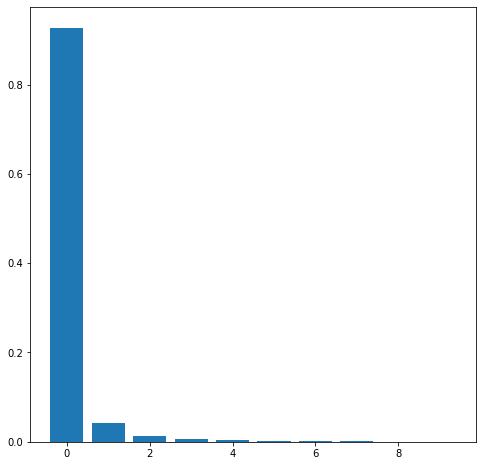

In [8]:
plt.figure(figsize=(8,8))
plt.bar(range(num_components), pca.explained_variance_ratio_)
plt.show()

In [6]:
def fit_eclipse(x,y):
    N = 300
    xmean, ymean = x.mean(), y.mean()
    x -= xmean
    y -= ymean
    U, S, V = np.linalg.svd(np.stack((x, y)))

    tt = np.linspace(0, 2*np.pi, 1000)
    circle = np.stack((np.cos(tt), np.sin(tt)))    # unit circle
    transform = np.sqrt(2/N) * U.dot(np.diag(S))   # transformation matrix
    fit = transform.dot(circle) + np.array([[xmean], [ymean]])
    return fit
    plt.plot(fit[0, :], fit[1, :], 'r')

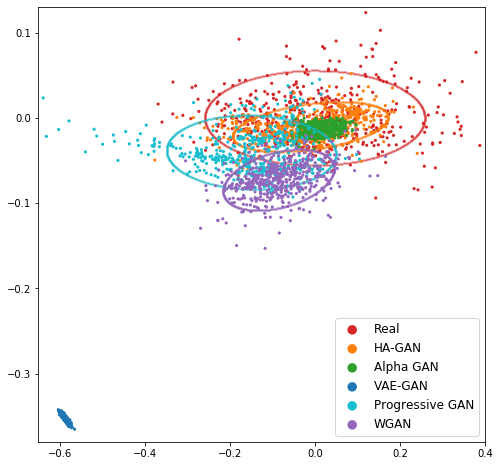

In [9]:
colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'tab:cyan', 'tab:purple']
models = ["Real", "HA-GAN", "Alpha GAN", "VAE-GAN", "Progressive GAN", "WGAN"]

fig, ax = plt.subplots(figsize=(8, 8))

for i in range(6):
    ax.scatter(pred_arr_list_pca[num_samples*i:num_samples*(i+1),0], pred_arr_list_pca[num_samples*i:num_samples*(i+1),1],
               c=colors[i], s=10, label=models[i],
               alpha=1, edgecolors='none')
    fit = fit_eclipse(pred_arr_list_pca[num_samples*i:num_samples*(i+1),0].copy(),\
                      pred_arr_list_pca[num_samples*i:num_samples*(i+1),1].copy())
    ax.scatter(fit[0, :], fit[1, :], c=colors[i], s=2, alpha=0.2)

ax.legend()
#ax.grid(True)

plt.xlim(-0.65, 0.4)
plt.ylim(-0.38, 0.13)

plt.legend(prop={'size': 12}, markerscale=3.)
#plt.show()
plt.savefig("./results/PCA_GSP.pdf", bbox_inches='tight')

## MMD

In [10]:
from torch_two_sample.statistics_diff import MMDStatistic
import torch

mmd = MMDStatistic(num_samples, num_samples)

In [13]:
for i, model_name in enumerate(["Real_train", "HA_GAN", "HA_GAN_wo_Encoder", "baseline_Alpha_GAN", "baseline_VAEGAN", "baseline_PGAN", "baseline_WGAN"]):
    print(model_name)
    sample_1 = torch.from_numpy(np.load("./results/pred_arr_GSP_Real.npy"))
    sample_2 = torch.from_numpy(np.load("./results/pred_arr_GSP_"+model_name+".npy"))

    test_statistics, ret_matrix = mmd(sample_1, sample_2, alphas='median', ret_matrix=True)
    #p = mmd.pval(ret_matrix.float(), n_permutations=1000)

    print("Test statistics:", test_statistics.item())
    #print("P-value:", p)

Real_train
Test statistics: 0.00153191022840643
HA_GAN
Test statistics: 0.04103153137893556
HA_GAN_wo_Encoder
Test statistics: 0.07278640810433823
baseline_Alpha_GAN
Test statistics: 0.4157010212479436
baseline_VAEGAN
Test statistics: 1.5765381317823641
baseline_PGAN
Test statistics: 0.3537243611984566
baseline_WGAN
Test statistics: 0.37692219323692006


## FID

In [14]:
from scipy import linalg

In [15]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).

    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

def post_process(act):
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [16]:
def calculate_fid_fake(args):
    act = generate_samples(args)
    m2, s2 = post_process(act)
    #m2 = np.load("./results/fid/m_real_train_GSP_v4data_size_"+str(args.img_size)+"_resnet50_v2.npy")
    #s2 = np.load("./results/fid/s_real_train_GSP_v4data_size_"+str(args.img_size)+"_resnet50_v2.npy")

    m1 = np.load("./results/fid/m_real_"+args.real_suffix+".npy")
    s1 = np.load("./results/fid/s_real_"+args.real_suffix+".npy")

    fid_value = calculate_frechet_distance(m1, s1, m2, s2)
    print('FID: ', fid_value)

In [18]:
act_real = np.load("./results/pred_arr_GSP_Real_v4data.npy")
m_real, s_real = post_process(act_real)

for i, model_name in enumerate(["Real_train", "HA_GAN_80000", "HA_GAN_wo_Encoder_78000", "baseline_Alpha_GAN_40000", "baseline_VAEGAN_78000", "baseline_PGAN", "baseline_WGAN_78000"]):
    print(model_name)
    act_test = np.load("./results/pred_arr_GSP_"+model_name+"_v4data.npy")
    m_test, s_test = post_process(act_test)

    fid_value = calculate_frechet_distance(m_real, s_real, m_test, s_test)
    print('FID: ', fid_value)

Real_train
FID:  2.3018945520210388e-05
HA_GAN
FID:  0.0025957154966777564
HA_GAN_wo_Encoder
FID:  0.007409581053759107
baseline_Alpha_GAN
FID:  0.014584517694325767
baseline_VAEGAN
FID:  0.5061383914065779
baseline_PGAN
FID:  0.028703499258609565
baseline_WGAN
FID:  0.01897051181774176
